# 1. Build an image segmentation model using pytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from typing import OrderedDict
from tqdm import tqdm
from warnings import filterwarnings
from torchmetrics import JaccardIndex, F1Score, Dice
import os
from torchsummary import summary
import gc
filterwarnings('ignore')


In [2]:

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
class BirdSoundDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_size = target_size
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        # Resize images and masks
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask


transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = BirdSoundDataset('new_dataset/train/images', 'new_dataset/train/masks', transform=transform)
valid_dataset = BirdSoundDataset('new_dataset/valid/images', 'new_dataset/valid/masks', transform=transform)
test_dataset = BirdSoundDataset('new_dataset/test/images', 'new_dataset/test/masks', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [5]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(1000, 200, 300)

In [6]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([1, 128, 128]), torch.Size([1, 128, 128]))

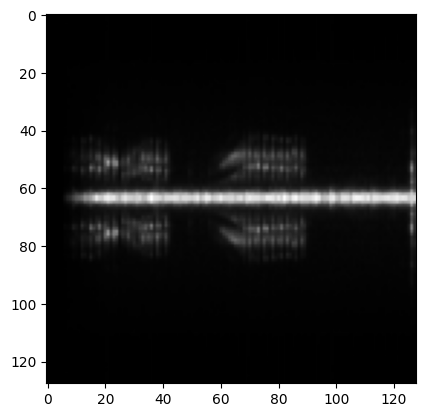

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Convert to (height, width, channels) for RGB images
plt.imshow(images[0].permute(1, 2, 0), cmap='gray')

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [36]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)),  # Changed in_channels to 1
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(32, 64, 3, 1, 1)),
            ('batchnorm1', nn.BatchNorm2d(64)),
            ('relu2', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('conv3', nn.Conv2d(64, 128, 3, 1, 1)),
            ('relu3', nn.ReLU()),
            ('conv4', nn.Conv2d(128, 216, 3, 1, 1)),
            ('relu4', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('conv5', nn.Conv2d(216, 128, 3, 1, 1)),
            ('relu5', nn.ReLU()),
            ('conv6', nn.Conv2d(128, 64, 3, 1, 1)),
            ('batchnorm', nn.BatchNorm2d(64)),
            ('relu6', nn.ReLU()),
            ('pool3', nn.MaxPool2d(kernel_size=2, stride=2)),
        ]))

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 216, kernel_size=2, stride=2),
            nn.BatchNorm2d(216),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(216, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(x)

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec


model = SegmentationModel().to(device)

In [11]:

summary(model, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
              ReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          18,496
       BatchNorm2d-4         [-1, 64, 128, 128]             128
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
              ReLU-8          [-1, 128, 64, 64]               0
            Conv2d-9          [-1, 216, 64, 64]         249,048
             ReLU-10          [-1, 216, 64, 64]               0
        MaxPool2d-11          [-1, 216, 32, 32]               0
           Conv2d-12          [-1, 128, 32, 32]         248,960
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 64,

# 2. Train your model using [Bird sound datasets](https://yuad-my.sharepoint.com/personal/youshan_zhang_yu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fyoushan%5Fzhang%5Fyu%5Fedu%2FDocuments%2FBird%5FSound%5FDataset&ga=1)

In [37]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

In [38]:
# Training loop
num_epochs = 75
torch.cuda.manual_seed(8)

train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {round(train_loss,4)}')

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, masks in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", unit="batch"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
        val_loss /= len(valid_loader)
        val_losses.append(val_loss)
        print(f'Validation Loss: {round(val_loss,4)}')
    
    scheduler.step(round(val_loss,4))

Training Epoch 1/75: 100%|██████████| 63/63 [00:27<00:00,  2.28batch/s]


Epoch 1/75, Loss: 0.1668


  1%|▏         | 1/75 [00:32<40:05, 32.51s/it]

Validation Loss: 0.1593


Training Epoch 2/75: 100%|██████████| 63/63 [00:27<00:00,  2.31batch/s]


Epoch 2/75, Loss: 0.1123


  3%|▎         | 2/75 [01:04<39:16, 32.28s/it]

Validation Loss: 0.1076


Training Epoch 3/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 3/75, Loss: 0.1081


  4%|▍         | 3/75 [01:36<38:40, 32.23s/it]

Validation Loss: 0.0981


Training Epoch 4/75: 100%|██████████| 63/63 [00:26<00:00,  2.33batch/s]


Epoch 4/75, Loss: 0.1014


  5%|▌         | 4/75 [02:08<37:56, 32.06s/it]

Validation Loss: 0.0876


Training Epoch 5/75: 100%|██████████| 63/63 [00:27<00:00,  2.30batch/s]


Epoch 5/75, Loss: 0.097


  7%|▋         | 5/75 [02:41<37:33, 32.19s/it]

Validation Loss: 0.0838


Training Epoch 6/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 6/75, Loss: 0.0945


  8%|▊         | 6/75 [03:13<37:03, 32.22s/it]

Validation Loss: 0.1031


Training Epoch 7/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 7/75, Loss: 0.0927


  9%|▉         | 7/75 [03:45<36:33, 32.25s/it]

Validation Loss: 0.085


Training Epoch 8/75: 100%|██████████| 63/63 [00:27<00:00,  2.30batch/s]


Epoch 8/75, Loss: 0.0868


 11%|█         | 8/75 [04:17<35:59, 32.24s/it]

Validation Loss: 0.0893


Training Epoch 9/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 9/75, Loss: 0.0831


 12%|█▏        | 9/75 [04:50<35:27, 32.23s/it]

Validation Loss: 0.0777


Training Epoch 10/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 10/75, Loss: 0.0819


 13%|█▎        | 10/75 [05:22<34:49, 32.15s/it]

Validation Loss: 0.0774


Training Epoch 11/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 11/75, Loss: 0.0798


 15%|█▍        | 11/75 [05:54<34:19, 32.18s/it]

Validation Loss: 0.0822


Training Epoch 12/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 12/75, Loss: 0.0776


 16%|█▌        | 12/75 [06:26<33:42, 32.10s/it]

Validation Loss: 0.0789


Training Epoch 13/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 13/75, Loss: 0.0777


 17%|█▋        | 13/75 [06:58<33:19, 32.25s/it]

Validation Loss: 0.0761


Training Epoch 14/75: 100%|██████████| 63/63 [00:26<00:00,  2.33batch/s]


Epoch 14/75, Loss: 0.0757


 19%|█▊        | 14/75 [07:30<32:37, 32.10s/it]

Validation Loss: 0.297


Training Epoch 15/75: 100%|██████████| 63/63 [00:27<00:00,  2.31batch/s]


Epoch 15/75, Loss: 0.0748


 20%|██        | 15/75 [08:02<32:07, 32.12s/it]

Validation Loss: 0.0736


Training Epoch 16/75: 100%|██████████| 63/63 [00:27<00:00,  2.30batch/s]


Epoch 16/75, Loss: 0.0735


 21%|██▏       | 16/75 [08:35<31:40, 32.21s/it]

Validation Loss: 0.0757


Training Epoch 17/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 17/75, Loss: 0.0742


 23%|██▎       | 17/75 [09:07<31:11, 32.26s/it]

Validation Loss: 0.0759


Training Epoch 18/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 18/75, Loss: 0.0723


 24%|██▍       | 18/75 [09:39<30:39, 32.27s/it]

Validation Loss: 0.0754


Training Epoch 19/75: 100%|██████████| 63/63 [00:27<00:00,  2.28batch/s]


Epoch 19/75, Loss: 0.0681


 25%|██▌       | 19/75 [10:12<30:13, 32.38s/it]

Validation Loss: 0.0749


Training Epoch 20/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 20/75, Loss: 0.0681


 27%|██▋       | 20/75 [10:44<29:35, 32.28s/it]

Validation Loss: 0.079


Training Epoch 21/75: 100%|██████████| 63/63 [00:27<00:00,  2.31batch/s]


Epoch 21/75, Loss: 0.0662


 28%|██▊       | 21/75 [11:16<28:58, 32.19s/it]

Validation Loss: 0.0756


Training Epoch 22/75: 100%|██████████| 63/63 [00:27<00:00,  2.33batch/s]


Epoch 22/75, Loss: 0.064


 29%|██▉       | 22/75 [11:48<28:21, 32.10s/it]

Validation Loss: 0.0755


Training Epoch 23/75: 100%|██████████| 63/63 [00:27<00:00,  2.30batch/s]


Epoch 23/75, Loss: 0.0631


 31%|███       | 23/75 [12:20<27:49, 32.11s/it]

Validation Loss: 0.0752


Training Epoch 24/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 24/75, Loss: 0.0629


 32%|███▏      | 24/75 [12:52<27:14, 32.06s/it]

Validation Loss: 0.0762


Training Epoch 25/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 25/75, Loss: 0.061


 33%|███▎      | 25/75 [13:24<26:44, 32.08s/it]

Validation Loss: 0.0759


Training Epoch 26/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 26/75, Loss: 0.061


 35%|███▍      | 26/75 [13:56<26:09, 32.03s/it]

Validation Loss: 0.0772


Training Epoch 27/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 27/75, Loss: 0.0603


 36%|███▌      | 27/75 [14:28<25:36, 32.01s/it]

Validation Loss: 0.077


Training Epoch 28/75: 100%|██████████| 63/63 [00:27<00:00,  2.28batch/s]


Epoch 28/75, Loss: 0.0593


 37%|███▋      | 28/75 [15:00<25:09, 32.13s/it]

Validation Loss: 0.0778


Training Epoch 29/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 29/75, Loss: 0.059


 39%|███▊      | 29/75 [15:33<24:41, 32.20s/it]

Validation Loss: 0.0772


Training Epoch 30/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 30/75, Loss: 0.0593


 40%|████      | 30/75 [16:05<24:10, 32.24s/it]

Validation Loss: 0.0771


Training Epoch 31/75: 100%|██████████| 63/63 [00:27<00:00,  2.31batch/s]


Epoch 31/75, Loss: 0.0581


 41%|████▏     | 31/75 [16:37<23:36, 32.18s/it]

Validation Loss: 0.0779


Training Epoch 32/75: 100%|██████████| 63/63 [00:27<00:00,  2.33batch/s]


Epoch 32/75, Loss: 0.0589


 43%|████▎     | 32/75 [17:09<23:00, 32.11s/it]

Validation Loss: 0.0788


Training Epoch 33/75: 100%|██████████| 63/63 [00:26<00:00,  2.35batch/s]


Epoch 33/75, Loss: 0.0586


 44%|████▍     | 33/75 [17:41<22:21, 31.95s/it]

Validation Loss: 0.0782


Training Epoch 34/75: 100%|██████████| 63/63 [00:27<00:00,  2.30batch/s]


Epoch 34/75, Loss: 0.0579


 45%|████▌     | 34/75 [18:13<21:52, 32.01s/it]

Validation Loss: 0.0781


Training Epoch 35/75: 100%|██████████| 63/63 [00:27<00:00,  2.31batch/s]


Epoch 35/75, Loss: 0.0578


 47%|████▋     | 35/75 [18:45<21:23, 32.09s/it]

Validation Loss: 0.0782


Training Epoch 36/75: 100%|██████████| 63/63 [00:26<00:00,  2.34batch/s]


Epoch 36/75, Loss: 0.058


 48%|████▊     | 36/75 [19:17<20:47, 31.99s/it]

Validation Loss: 0.0782


Training Epoch 37/75: 100%|██████████| 63/63 [00:26<00:00,  2.33batch/s]


Epoch 37/75, Loss: 0.0577


 49%|████▉     | 37/75 [19:49<20:13, 31.94s/it]

Validation Loss: 0.0783


Training Epoch 38/75: 100%|██████████| 63/63 [00:27<00:00,  2.31batch/s]


Epoch 38/75, Loss: 0.0577


 51%|█████     | 38/75 [20:21<19:43, 31.99s/it]

Validation Loss: 0.0783


Training Epoch 39/75: 100%|██████████| 63/63 [00:27<00:00,  2.30batch/s]


Epoch 39/75, Loss: 0.0576


 52%|█████▏    | 39/75 [20:53<19:14, 32.07s/it]

Validation Loss: 0.0784


Training Epoch 40/75: 100%|██████████| 63/63 [00:27<00:00,  2.27batch/s]


Epoch 40/75, Loss: 0.0574


 53%|█████▎    | 40/75 [21:26<18:47, 32.21s/it]

Validation Loss: 0.0786


Training Epoch 41/75: 100%|██████████| 63/63 [00:27<00:00,  2.28batch/s]


Epoch 41/75, Loss: 0.0575


 55%|█████▍    | 41/75 [21:58<18:17, 32.28s/it]

Validation Loss: 0.0786


Training Epoch 42/75: 100%|██████████| 63/63 [00:27<00:00,  2.30batch/s]


Epoch 42/75, Loss: 0.0575


 56%|█████▌    | 42/75 [22:30<17:44, 32.24s/it]

Validation Loss: 0.0783


Training Epoch 43/75: 100%|██████████| 63/63 [00:27<00:00,  2.31batch/s]


Epoch 43/75, Loss: 0.0577


 57%|█████▋    | 43/75 [23:02<17:09, 32.17s/it]

Validation Loss: 0.0783


Training Epoch 44/75: 100%|██████████| 63/63 [00:27<00:00,  2.31batch/s]


Epoch 44/75, Loss: 0.0574


 59%|█████▊    | 44/75 [23:34<16:36, 32.13s/it]

Validation Loss: 0.0784


Training Epoch 45/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 45/75, Loss: 0.0576


 60%|██████    | 45/75 [24:06<16:02, 32.07s/it]

Validation Loss: 0.0785


Training Epoch 46/75: 100%|██████████| 63/63 [00:27<00:00,  2.30batch/s]


Epoch 46/75, Loss: 0.0575


 61%|██████▏   | 46/75 [24:38<15:31, 32.11s/it]

Validation Loss: 0.0783


Training Epoch 47/75: 100%|██████████| 63/63 [00:27<00:00,  2.31batch/s]


Epoch 47/75, Loss: 0.0573


 63%|██████▎   | 47/75 [25:10<14:58, 32.09s/it]

Validation Loss: 0.0783


Training Epoch 48/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 48/75, Loss: 0.0576


 64%|██████▍   | 48/75 [25:42<14:25, 32.05s/it]

Validation Loss: 0.0785


Training Epoch 49/75: 100%|██████████| 63/63 [00:27<00:00,  2.31batch/s]


Epoch 49/75, Loss: 0.0573


 65%|██████▌   | 49/75 [26:15<13:56, 32.16s/it]

Validation Loss: 0.0784


Training Epoch 50/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 50/75, Loss: 0.0573


 67%|██████▋   | 50/75 [26:47<13:25, 32.23s/it]

Validation Loss: 0.0785


Training Epoch 51/75: 100%|██████████| 63/63 [00:27<00:00,  2.27batch/s]


Epoch 51/75, Loss: 0.0574


 68%|██████▊   | 51/75 [27:20<12:56, 32.34s/it]

Validation Loss: 0.0784


Training Epoch 52/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 52/75, Loss: 0.0575


 69%|██████▉   | 52/75 [27:52<12:24, 32.37s/it]

Validation Loss: 0.0784


Training Epoch 53/75: 100%|██████████| 63/63 [00:27<00:00,  2.30batch/s]


Epoch 53/75, Loss: 0.0575


 71%|███████   | 53/75 [28:24<11:51, 32.34s/it]

Validation Loss: 0.0786


Training Epoch 54/75: 100%|██████████| 63/63 [00:27<00:00,  2.33batch/s]


Epoch 54/75, Loss: 0.0578


 72%|███████▏  | 54/75 [28:56<11:15, 32.18s/it]

Validation Loss: 0.0787


Training Epoch 55/75: 100%|██████████| 63/63 [00:27<00:00,  2.33batch/s]


Epoch 55/75, Loss: 0.0579


 73%|███████▎  | 55/75 [29:28<10:41, 32.06s/it]

Validation Loss: 0.0787


Training Epoch 56/75: 100%|██████████| 63/63 [00:27<00:00,  2.31batch/s]


Epoch 56/75, Loss: 0.0575


 75%|███████▍  | 56/75 [30:00<10:08, 32.04s/it]

Validation Loss: 0.0786


Training Epoch 57/75: 100%|██████████| 63/63 [00:27<00:00,  2.30batch/s]


Epoch 57/75, Loss: 0.0573


 76%|███████▌  | 57/75 [30:32<09:37, 32.11s/it]

Validation Loss: 0.0781


Training Epoch 58/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 58/75, Loss: 0.0573


 77%|███████▋  | 58/75 [31:04<09:04, 32.05s/it]

Validation Loss: 0.0781


Training Epoch 59/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 59/75, Loss: 0.0575


 79%|███████▊  | 59/75 [31:36<08:33, 32.11s/it]

Validation Loss: 0.0784


Training Epoch 60/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 60/75, Loss: 0.0576


 80%|████████  | 60/75 [32:08<08:00, 32.02s/it]

Validation Loss: 0.0785


Training Epoch 61/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 61/75, Loss: 0.0573


 81%|████████▏ | 61/75 [32:41<07:30, 32.16s/it]

Validation Loss: 0.0784


Training Epoch 62/75: 100%|██████████| 63/63 [00:27<00:00,  2.28batch/s]


Epoch 62/75, Loss: 0.0577


 83%|████████▎ | 62/75 [33:13<06:59, 32.27s/it]

Validation Loss: 0.0785


Training Epoch 63/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 63/75, Loss: 0.0573


 84%|████████▍ | 63/75 [33:46<06:27, 32.27s/it]

Validation Loss: 0.0788


Training Epoch 64/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 64/75, Loss: 0.0575


 85%|████████▌ | 64/75 [34:18<05:56, 32.39s/it]

Validation Loss: 0.0781


Training Epoch 65/75: 100%|██████████| 63/63 [00:27<00:00,  2.30batch/s]


Epoch 65/75, Loss: 0.0578


 87%|████████▋ | 65/75 [34:50<05:22, 32.30s/it]

Validation Loss: 0.0785


Training Epoch 66/75: 100%|██████████| 63/63 [00:27<00:00,  2.30batch/s]


Epoch 66/75, Loss: 0.0577


 88%|████████▊ | 66/75 [35:23<04:50, 32.30s/it]

Validation Loss: 0.0784


Training Epoch 67/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 67/75, Loss: 0.0573


 89%|████████▉ | 67/75 [35:54<04:17, 32.18s/it]

Validation Loss: 0.0784


Training Epoch 68/75: 100%|██████████| 63/63 [00:27<00:00,  2.31batch/s]


Epoch 68/75, Loss: 0.0571


 91%|█████████ | 68/75 [36:27<03:45, 32.21s/it]

Validation Loss: 0.0783


Training Epoch 69/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 69/75, Loss: 0.0572


 92%|█████████▏| 69/75 [36:59<03:12, 32.10s/it]

Validation Loss: 0.0784


Training Epoch 70/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 70/75, Loss: 0.0576


 93%|█████████▎| 70/75 [37:31<02:40, 32.06s/it]

Validation Loss: 0.0785


Training Epoch 71/75: 100%|██████████| 63/63 [00:27<00:00,  2.32batch/s]


Epoch 71/75, Loss: 0.0577


 95%|█████████▍| 71/75 [38:02<02:08, 32.01s/it]

Validation Loss: 0.0786


Training Epoch 72/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 72/75, Loss: 0.0576


 96%|█████████▌| 72/75 [38:35<01:36, 32.11s/it]

Validation Loss: 0.0785


Training Epoch 73/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 73/75, Loss: 0.0576


 97%|█████████▋| 73/75 [39:07<01:04, 32.25s/it]

Validation Loss: 0.0786


Training Epoch 74/75: 100%|██████████| 63/63 [00:27<00:00,  2.28batch/s]


Epoch 74/75, Loss: 0.0573


 99%|█████████▊| 74/75 [39:40<00:32, 32.35s/it]

Validation Loss: 0.0786


Training Epoch 75/75: 100%|██████████| 63/63 [00:27<00:00,  2.29batch/s]


Epoch 75/75, Loss: 0.0575


100%|██████████| 75/75 [40:12<00:00, 32.17s/it]

Validation Loss: 0.0783


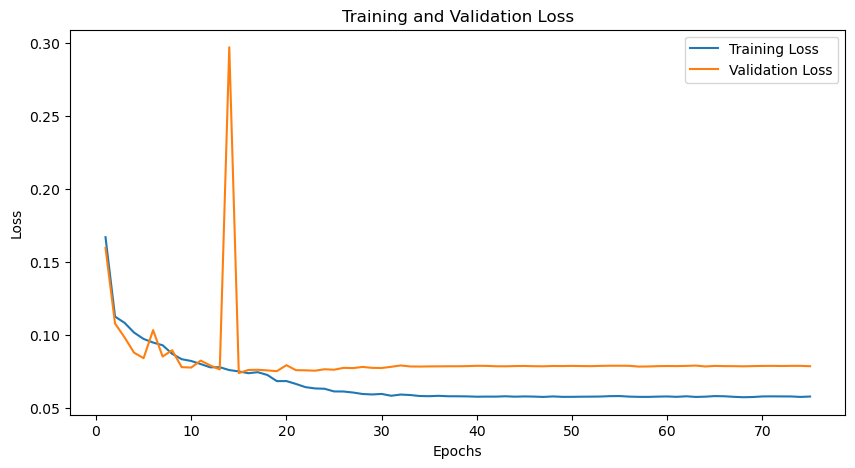

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')import torch

plt.legend()
plt.show()

# 3.Evaluate your model using the test images

In [9]:
# torch.save(model.state_dict(), 'model(61.07%).pth')

def load_model_weights(model, file_path='model(61.07%).pth'):
    model.load_state_dict(torch.load(file_path))
    print(f"Model weights loaded from {file_path}")


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)),  # Changed in_channels to 1
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(32, 64, 3, 1, 1)),
            ('batchnorm1', nn.BatchNorm2d(64)),
            ('relu2', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('conv3', nn.Conv2d(64, 128, 3, 1, 1)),
            ('relu3', nn.ReLU()),
            ('conv4', nn.Conv2d(128, 216, 3, 1, 1)),
            ('relu4', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('conv5', nn.Conv2d(216, 128, 3, 1, 1)),
            ('relu5', nn.ReLU()),
            ('conv6', nn.Conv2d(128, 64, 3, 1, 1)),
            ('batchnorm', nn.BatchNorm2d(64)),
            ('relu6', nn.ReLU()),
            ('pool3', nn.MaxPool2d(kernel_size=2, stride=2)),
        ]))

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 216, kernel_size=2, stride=2),
            nn.BatchNorm2d(216),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(216, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(x)

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec


    
model = SegmentationModel().to(device)
load_model_weights(model)

Model weights loaded from model(61.07%).pth


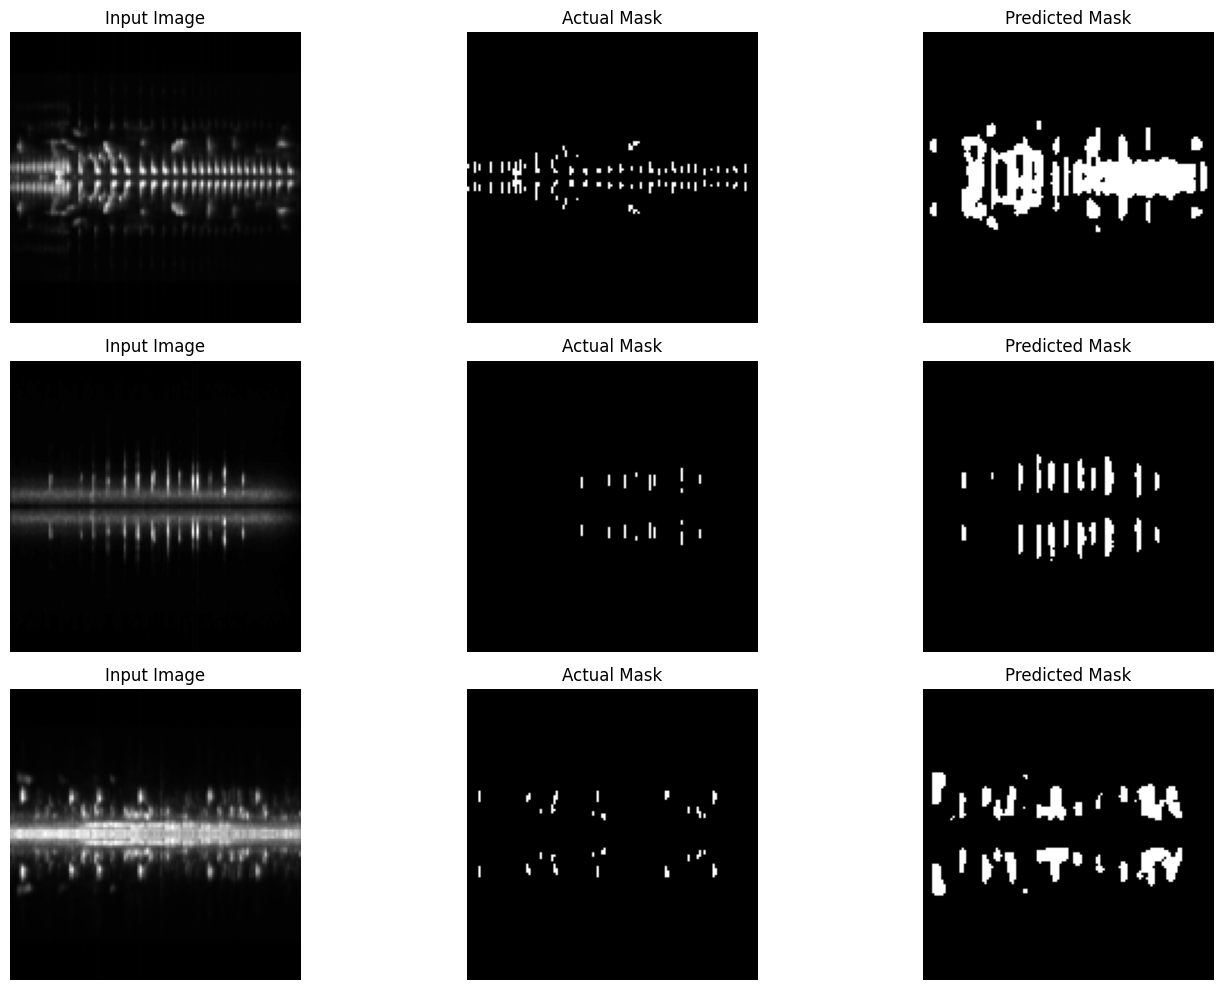

In [18]:
def plot_masks(images, actual_masks, predicted_masks, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')
        
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(actual_masks[i].squeeze(), cmap='gray')
        plt.title('Actual Mask')
        plt.axis('off')
        
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

images, actual_masks = next(iter(test_loader))
model.eval()
with torch.no_grad():
    images = images.to(device)
    predicted_masks = model(images)
    predicted_masks = (predicted_masks > 0.5).float()

plot_masks(images.cpu(), actual_masks.cpu(), predicted_masks.cpu(), num_images= 3)

# 4. Your IoU score should be higher than 60

In [10]:
iou_metric = JaccardIndex(task='binary')
f1_metric = F1Score(task='binary')
dice_metric = Dice()

model.eval()
all_iou_scores = []
all_f1_scores = []
all_dice_scores = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, unit="batch"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images).cpu()
        outputs = (outputs > 0.5).float()
        
        iou = iou_metric(outputs, masks.int().cpu())
        f1 = f1_metric(outputs, masks.int().cpu())
        dice = dice_metric(outputs, masks.int().cpu())
        
        all_iou_scores.append(iou.item())
        all_f1_scores.append(f1.item())
        all_dice_scores.append(dice.item())

mean_iou = np.mean(all_iou_scores)
mean_f1 = np.mean(all_f1_scores)
mean_dice = np.mean(all_dice_scores)

print(f'Mean IoU score: {round(mean_iou, 4)}')
print(f'Mean F1 score: {round(mean_f1,4)}')
print(f'Mean Dice score: {round(mean_dice, 4)}')


100%|██████████| 19/19 [00:09<00:00,  2.07batch/s]

Mean IoU score: 0.6107
Mean F1 score: 0.7534
Mean Dice score: 0.7534


In [11]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

# 5. Write a 3-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


### Research Gate Link : https://www.researchgate.net/publication/382931573_Bird_Sound_Spectrogram_Segmentation_Using_Deep_Learning
### Github Weight Link : https://github.com/Nurath/Bird-Sound-Spectrogram-Segmentation-Using-Deep-Learning-Weights